In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.autograd as autograd
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
from IPython.display import HTML

from PIL import Image

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


In [2]:
# Root directory for dataset
dataroot = "/home/ubuntu/exp/swivel/data/shapenet/shapenet_images_128_1.5/02691156"

# Number of workers for dataloader
workers = 1

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 4

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Number of training epochs
num_epochs = 1000

# Learning rate for optimizers
lr_D = 0.00002
lr_G = 0.0002
lr_R = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
beta2 = 0.999

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

resume = True

checkpoint_file = 'swivel_gan_final_qp_z_reconmean_double1-5_00002_lap.pth'

def show_images(images):
    images = images[:, :3] 
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(np.transpose(img, (1,2,0)))
#         plt.imshow(img.reshape([image_size, image_size, 3]))
    return 

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset

def pil_alpha_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGBA')
    
    
dataset = dset.ImageFolder(root=dataroot,
            transform=transforms.ToTensor(),
            loader = pil_alpha_loader,
        )
num_data = len(dataset) - len(dataset) % batch_size
print(num_data)
                
# Create the dataloader
prelim_dataloader = torch.utils.data.DataLoader(dataset, batch_size=num_data,
                                         shuffle=True, num_workers=0)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Retrieve all data
total_batch = next(iter(prelim_dataloader))
# plt.figure(figsize=(8,600))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(total_batch[0].to(device)[:num_data], padding=2, normalize=True).cpu(),(1,2,0)))

4032


In [4]:
dataset_tensor = total_batch[0]
print(dataset_tensor.shape)

torch.Size([4032, 4, 128, 128])


In [5]:
from torch.utils.data import TensorDataset

tensor_dataset = TensorDataset(dataset_tensor)
print(len(tensor_dataset))

dataloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=0, pin_memory=True
                                        )



4032


In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
from models import RenderedGenerator, Discriminator, ReverseGenerator

netG = RenderedGenerator(batch_size=batch_size, z_dim=nz, image_size=image_size, random_pose=True).cuda()
netG.apply(weights_init)

netD = Discriminator(image_size=image_size, image_channels=4).cuda()
netD.apply(weights_init)

netR = ReverseGenerator(batch_size=batch_size, z_dim=nz).cuda()
netR.apply(weights_init)


ReverseGenerator(
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1926, out_features=1024, bias=True)
  (relu): LeakyReLU(negative_slope=0.2, inplace)
)

In [8]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in netG.state_dict():
    print(param_tensor, "\t", netG.state_dict()[param_tensor].size())

Model's state_dict:
mesh_generator.fc1.weight 	 torch.Size([1024, 100])
mesh_generator.fc1.bias 	 torch.Size([1024])
mesh_generator.bn1.weight 	 torch.Size([1024])
mesh_generator.bn1.bias 	 torch.Size([1024])
mesh_generator.bn1.running_mean 	 torch.Size([1024])
mesh_generator.bn1.running_var 	 torch.Size([1024])
mesh_generator.bn1.num_batches_tracked 	 torch.Size([])
mesh_generator.fc2.weight 	 torch.Size([1024, 1024])
mesh_generator.fc2.bias 	 torch.Size([1024])
mesh_generator.bn2.weight 	 torch.Size([1024])
mesh_generator.bn2.bias 	 torch.Size([1024])
mesh_generator.bn2.running_mean 	 torch.Size([1024])
mesh_generator.bn2.running_var 	 torch.Size([1024])
mesh_generator.bn2.num_batches_tracked 	 torch.Size([])
mesh_generator.fc_bias.weight 	 torch.Size([1926, 1024])
mesh_generator.fc_bias.bias 	 torch.Size([1926])


In [9]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.Tensor(batch_size, nz).normal_(0,1).cuda()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizer_D = optim.Adam(netD.parameters(), lr=lr_D, betas=(beta1, 0.999))
optimizer_G = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, 0.999))
optimizer_R = optim.Adam(netR.parameters(), lr=lr_R, betas=(beta1, 0.999))

In [10]:
# Loss weight for gradient penalty
lambda_gp = 10

def compute_gradient_penalty(D, real_samples, fake_samples, fake_tensor):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.cuda.FloatTensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake_tensor,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty * lambda_gp



w_gp_loss = False

def discriminator_regularizer(d_real_logits, d_real_arg, d_fake_logits, d_fake_arg):
    D1 = torch.sigmoid(d_real_logits)
    D2 = torch.sigmoid(d_fake_logits)
    grad_D1_logits = torch.autograd.grad(d_real_logits, d_real_arg)
    grad_D2_logits = torch.autograd.grad(d_fake_logits, d_fake_arg)
    grad_D1_logits_norm = torch.norm(grad_D1_logits.view(grad_D1_logits.size(0), -1), axis=1, keepdim=True)
    grad_D2_logits_norm = torch.norm(grad_D2_logits.view(grad_D2_logits.size(0), -1), axis=1, keepdim=True)

    #set keep_dims=True/False such that grad_D_logits_norm.shape == D.shape
    assert grad_D1_logits_norm.shape == D1.shape
    assert grad_D2_logits_norm.shape == D2.shape

    reg_D1 = torch.square(1.0-D1) * torch.square(grad_D1_logits_norm)
    reg_D2 = torch.square(D2) * torch.square(grad_D2_logits_norm)
    disc_regularizer = torch.mean(reg_D1 + reg_D2)
    return disc_regularizer

grad_reg_loss = False


Starting Training Loop...
[Epoch 0/1000] [Batch 0/63] [D loss: -0.000415][G loss: 0.000415][Lap loss: 424.886780][z loss: 1.345975] D(x): 0.0079 D(G(z)): 0.0075


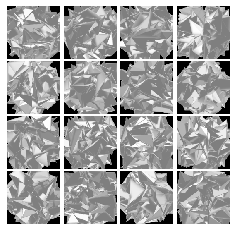

[Epoch 0/1000] [Batch 50/63] [D loss: -0.000604][G loss: 0.000499][Lap loss: 143.799149][z loss: 0.390753] D(x): 0.0079 D(G(z)): 0.0074
[Epoch 1/1000] [Batch 0/63] [D loss: -0.000667][G loss: 0.000788][Lap loss: 125.681282][z loss: 0.405562] D(x): 0.0080 D(G(z)): 0.0072
[Epoch 1/1000] [Batch 50/63] [D loss: -0.000661][G loss: 0.000645][Lap loss: 89.919144][z loss: 0.461994] D(x): 0.0082 D(G(z)): 0.0076
[Epoch 2/1000] [Batch 0/63] [D loss: -0.000614][G loss: 0.000405][Lap loss: 83.490982][z loss: 0.490972] D(x): 0.0077 D(G(z)): 0.0073
[Epoch 2/1000] [Batch 50/63] [D loss: -0.000547][G loss: 0.000617][Lap loss: 64.087845][z loss: 0.601856] D(x): 0.0080 D(G(z)): 0.0074
[Epoch 3/1000] [Batch 0/63] [D loss: -0.000478][G loss: 0.000714][Lap loss: 58.584778][z loss: 0.625943] D(x): 0.0080 D(G(z)): 0.0073
[Epoch 3/1000] [Batch 50/63] [D loss: -0.000609][G loss: 0.000436][Lap loss: 45.147903][z loss: 0.873637] D(x): 0.0080 D(G(z)): 0.0076
[Epoch 4/1000] [Batch 0/63] [D loss: -0.000532][G loss: 

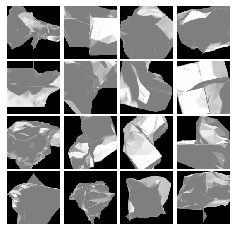

[Epoch 8/1000] [Batch 0/63] [D loss: -0.000377][G loss: 0.000231][Lap loss: 15.791338][z loss: 2.754913] D(x): 0.0078 D(G(z)): 0.0076
[Epoch 8/1000] [Batch 50/63] [D loss: -0.000389][G loss: 0.000442][Lap loss: 14.629336][z loss: 3.082467] D(x): 0.0081 D(G(z)): 0.0077
[Epoch 9/1000] [Batch 0/63] [D loss: -0.000359][G loss: 0.000291][Lap loss: 13.944442][z loss: 3.276208] D(x): 0.0079 D(G(z)): 0.0076
[Epoch 9/1000] [Batch 50/63] [D loss: -0.000453][G loss: 0.000238][Lap loss: 11.669796][z loss: 2.905072] D(x): 0.0080 D(G(z)): 0.0077
[Epoch 10/1000] [Batch 0/63] [D loss: -0.000158][G loss: 0.000297][Lap loss: 11.450142][z loss: 2.938995] D(x): 0.0079 D(G(z)): 0.0076
[Epoch 10/1000] [Batch 50/63] [D loss: -0.000414][G loss: 0.000659][Lap loss: 10.261596][z loss: 2.558032] D(x): 0.0080 D(G(z)): 0.0073
[Epoch 11/1000] [Batch 0/63] [D loss: 0.000033][G loss: 0.000264][Lap loss: 10.081135][z loss: 2.757503] D(x): 0.0079 D(G(z)): 0.0076
[Epoch 11/1000] [Batch 50/63] [D loss: -0.000338][G loss:

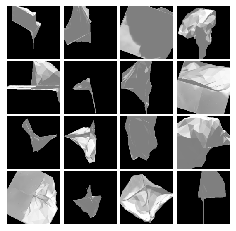

[Epoch 16/1000] [Batch 0/63] [D loss: -0.000515][G loss: 0.000428][Lap loss: 5.408815][z loss: 4.403572] D(x): 0.0080 D(G(z)): 0.0075
[Epoch 16/1000] [Batch 50/63] [D loss: -0.000238][G loss: 0.000602][Lap loss: 4.782484][z loss: 4.208267] D(x): 0.0080 D(G(z)): 0.0074
[Epoch 17/1000] [Batch 0/63] [D loss: -0.000223][G loss: 0.000271][Lap loss: 4.955291][z loss: 4.045338] D(x): 0.0079 D(G(z)): 0.0077
[Epoch 17/1000] [Batch 50/63] [D loss: -0.000105][G loss: 0.000262][Lap loss: 4.251988][z loss: 3.585552] D(x): 0.0079 D(G(z)): 0.0077
[Epoch 18/1000] [Batch 0/63] [D loss: -0.000463][G loss: 0.000358][Lap loss: 4.050574][z loss: 3.410518] D(x): 0.0080 D(G(z)): 0.0076
[Epoch 18/1000] [Batch 50/63] [D loss: -0.000303][G loss: 0.000490][Lap loss: 4.881350][z loss: 3.271322] D(x): 0.0080 D(G(z)): 0.0075
[Epoch 19/1000] [Batch 0/63] [D loss: -0.000267][G loss: 0.000198][Lap loss: 3.963191][z loss: 3.997088] D(x): 0.0079 D(G(z)): 0.0078
[Epoch 19/1000] [Batch 50/63] [D loss: -0.000178][G loss: 0

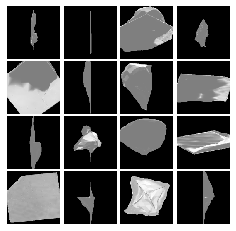

[Epoch 24/1000] [Batch 0/63] [D loss: 0.000005][G loss: 0.000158][Lap loss: 2.669464][z loss: 3.463397] D(x): 0.0079 D(G(z)): 0.0078
[Epoch 24/1000] [Batch 50/63] [D loss: -0.000413][G loss: 0.000479][Lap loss: 2.724960][z loss: 3.289023] D(x): 0.0081 D(G(z)): 0.0076
[Epoch 25/1000] [Batch 0/63] [D loss: -0.000420][G loss: 0.000391][Lap loss: 2.896481][z loss: 3.225673] D(x): 0.0081 D(G(z)): 0.0077
[Epoch 25/1000] [Batch 50/63] [D loss: -0.000025][G loss: 0.000291][Lap loss: 2.651791][z loss: 3.103319] D(x): 0.0080 D(G(z)): 0.0077
[Epoch 26/1000] [Batch 0/63] [D loss: -0.000394][G loss: 0.000386][Lap loss: 2.417102][z loss: 2.965894] D(x): 0.0080 D(G(z)): 0.0076
[Epoch 26/1000] [Batch 50/63] [D loss: -0.000358][G loss: 0.000214][Lap loss: 3.204555][z loss: 2.731164] D(x): 0.0080 D(G(z)): 0.0078
[Epoch 27/1000] [Batch 0/63] [D loss: -0.000146][G loss: 0.000387][Lap loss: 2.156899][z loss: 2.717302] D(x): 0.0080 D(G(z)): 0.0076
[Epoch 27/1000] [Batch 50/63] [D loss: -0.000401][G loss: 0.

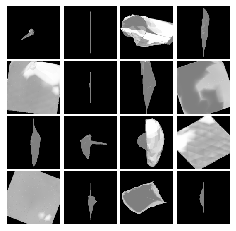

[Epoch 31/1000] [Batch 50/63] [D loss: -0.000395][G loss: 0.000253][Lap loss: 2.460350][z loss: 1.678361] D(x): 0.0080 D(G(z)): 0.0078
[Epoch 32/1000] [Batch 0/63] [D loss: -0.000162][G loss: 0.000128][Lap loss: 2.329887][z loss: 1.673248] D(x): 0.0078 D(G(z)): 0.0077
[Epoch 32/1000] [Batch 50/63] [D loss: -0.000470][G loss: 0.000526][Lap loss: 2.256918][z loss: 1.691156] D(x): 0.0080 D(G(z)): 0.0075
[Epoch 33/1000] [Batch 0/63] [D loss: -0.000478][G loss: 0.000148][Lap loss: 2.942414][z loss: 1.611094] D(x): 0.0078 D(G(z)): 0.0077
[Epoch 33/1000] [Batch 50/63] [D loss: -0.000311][G loss: 0.000269][Lap loss: 1.855741][z loss: 1.549830] D(x): 0.0079 D(G(z)): 0.0077
[Epoch 34/1000] [Batch 0/63] [D loss: -0.000290][G loss: 0.000497][Lap loss: 2.088202][z loss: 1.515173] D(x): 0.0080 D(G(z)): 0.0075
[Epoch 34/1000] [Batch 50/63] [D loss: -0.000242][G loss: 0.000319][Lap loss: 1.770755][z loss: 1.453846] D(x): 0.0080 D(G(z)): 0.0077
[Epoch 35/1000] [Batch 0/63] [D loss: -0.000304][G loss: 0

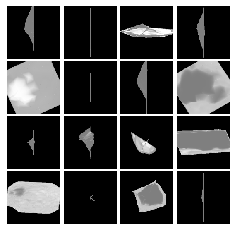

[Epoch 39/1000] [Batch 50/63] [D loss: -0.000333][G loss: 0.000077][Lap loss: 1.639138][z loss: 1.279713] D(x): 0.0079 D(G(z)): 0.0078
[Epoch 40/1000] [Batch 0/63] [D loss: -0.000362][G loss: 0.000224][Lap loss: 1.348032][z loss: 1.263274] D(x): 0.0079 D(G(z)): 0.0077
[Epoch 40/1000] [Batch 50/63] [D loss: -0.000149][G loss: 0.000354][Lap loss: 1.294692][z loss: 1.258911] D(x): 0.0080 D(G(z)): 0.0077
[Epoch 41/1000] [Batch 0/63] [D loss: -0.000099][G loss: 0.000217][Lap loss: 2.239636][z loss: 1.225067] D(x): 0.0079 D(G(z)): 0.0077
[Epoch 41/1000] [Batch 50/63] [D loss: -0.000372][G loss: 0.000200][Lap loss: 1.735288][z loss: 1.242810] D(x): 0.0079 D(G(z)): 0.0077
Laplacian has been initialized. Discriminator will begin training.
[Epoch 42/1000] [Batch 0/63] [D loss: -0.000603][G loss: 0.000566][Lap loss: 1.268831][z loss: 1.224951] D(x): 0.0082 D(G(z)): 0.0076
[Epoch 42/1000] [Batch 50/63] [D loss: -0.094594][G loss: 0.097326][Lap loss: 1.677680][z loss: 1.179034] D(x): 0.0662 D(G(z))

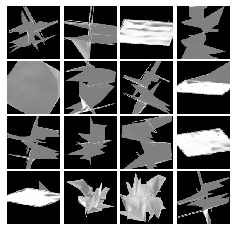

[Epoch 47/1000] [Batch 50/63] [D loss: -4.201826][G loss: 8.228848][Lap loss: 53.657864][z loss: 1.384404] D(x): 5.1422 D(G(z)): -3.0866
[Epoch 48/1000] [Batch 0/63] [D loss: -4.227851][G loss: 8.329463][Lap loss: 61.091927][z loss: 1.336104] D(x): 5.2601 D(G(z)): -3.0693
[Epoch 48/1000] [Batch 50/63] [D loss: -3.898853][G loss: 7.840374][Lap loss: 52.995552][z loss: 1.543617] D(x): 4.5386 D(G(z)): -3.3018
[Epoch 49/1000] [Batch 0/63] [D loss: -4.047288][G loss: 7.707590][Lap loss: 48.725220][z loss: 1.514919] D(x): 4.5299 D(G(z)): -3.1777
[Epoch 49/1000] [Batch 50/63] [D loss: -4.075964][G loss: 8.029005][Lap loss: 47.652275][z loss: 1.437838] D(x): 4.7682 D(G(z)): -3.2608
[Epoch 50/1000] [Batch 0/63] [D loss: -4.213320][G loss: 7.868050][Lap loss: 50.844299][z loss: 1.487704] D(x): 4.7715 D(G(z)): -3.0965
[Epoch 50/1000] [Batch 50/63] [D loss: -4.021806][G loss: 8.261955][Lap loss: 44.197250][z loss: 1.360022] D(x): 5.1331 D(G(z)): -3.1288
[Epoch 51/1000] [Batch 0/63] [D loss: -3.734

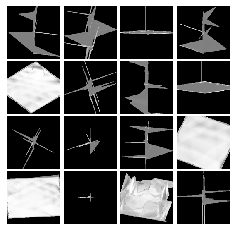

[Epoch 55/1000] [Batch 50/63] [D loss: -3.790731][G loss: 7.892603][Lap loss: 31.939224][z loss: 1.598123] D(x): 4.5813 D(G(z)): -3.3113
[Epoch 56/1000] [Batch 0/63] [D loss: -3.795759][G loss: 7.320658][Lap loss: 34.709137][z loss: 1.645559] D(x): 4.2591 D(G(z)): -3.0615
[Epoch 56/1000] [Batch 50/63] [D loss: -3.983262][G loss: 7.830287][Lap loss: 34.812008][z loss: 1.688090] D(x): 4.1588 D(G(z)): -3.6715
[Epoch 57/1000] [Batch 0/63] [D loss: -3.845147][G loss: 7.684781][Lap loss: 35.212257][z loss: 1.611123] D(x): 4.3686 D(G(z)): -3.3162
[Epoch 57/1000] [Batch 50/63] [D loss: -4.027730][G loss: 8.119668][Lap loss: 37.660736][z loss: 1.579636] D(x): 4.5290 D(G(z)): -3.5907
[Epoch 58/1000] [Batch 0/63] [D loss: -4.090978][G loss: 7.859608][Lap loss: 31.408272][z loss: 1.803226] D(x): 4.4404 D(G(z)): -3.4192
[Epoch 58/1000] [Batch 50/63] [D loss: -3.769038][G loss: 8.030192][Lap loss: 36.461681][z loss: 1.947393] D(x): 4.3985 D(G(z)): -3.6317
[Epoch 59/1000] [Batch 0/63] [D loss: -3.721

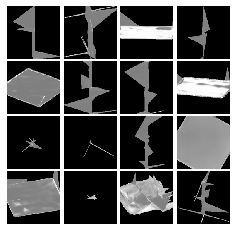

[Epoch 63/1000] [Batch 50/63] [D loss: -4.044044][G loss: 7.798419][Lap loss: 34.413818][z loss: 1.974873] D(x): 3.9920 D(G(z)): -3.8064
[Epoch 64/1000] [Batch 0/63] [D loss: -3.807665][G loss: 8.110256][Lap loss: 32.898125][z loss: 2.283735] D(x): 3.9916 D(G(z)): -4.1187
[Epoch 64/1000] [Batch 50/63] [D loss: -3.925066][G loss: 7.753213][Lap loss: 26.813061][z loss: 2.237219] D(x): 3.7495 D(G(z)): -4.0037
[Epoch 65/1000] [Batch 0/63] [D loss: -3.850313][G loss: 7.844722][Lap loss: 28.950638][z loss: 2.280461] D(x): 4.0047 D(G(z)): -3.8400
[Epoch 65/1000] [Batch 50/63] [D loss: -4.064772][G loss: 7.553979][Lap loss: 26.522655][z loss: 2.180593] D(x): 3.8248 D(G(z)): -3.7292
[Epoch 66/1000] [Batch 0/63] [D loss: -3.728712][G loss: 7.316944][Lap loss: 24.660957][z loss: 2.386106] D(x): 3.9703 D(G(z)): -3.3466
[Epoch 66/1000] [Batch 50/63] [D loss: -3.640357][G loss: 7.289376][Lap loss: 23.601021][z loss: 2.082409] D(x): 3.9447 D(G(z)): -3.3446
[Epoch 67/1000] [Batch 0/63] [D loss: -4.085

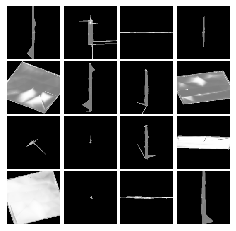

[Epoch 71/1000] [Batch 50/63] [D loss: -3.660554][G loss: 7.553837][Lap loss: 22.312569][z loss: 2.648158] D(x): 3.8009 D(G(z)): -3.7529
[Epoch 72/1000] [Batch 0/63] [D loss: -3.740077][G loss: 7.564964][Lap loss: 20.937920][z loss: 2.894758] D(x): 3.3223 D(G(z)): -4.2427
[Epoch 72/1000] [Batch 50/63] [D loss: -3.703090][G loss: 6.788818][Lap loss: 21.395237][z loss: 2.243025] D(x): 3.4812 D(G(z)): -3.3076
[Epoch 73/1000] [Batch 0/63] [D loss: -3.593506][G loss: 7.589689][Lap loss: 22.429586][z loss: 2.760133] D(x): 3.5512 D(G(z)): -4.0385
[Epoch 73/1000] [Batch 50/63] [D loss: -3.776665][G loss: 7.719222][Lap loss: 20.134655][z loss: 2.166607] D(x): 3.4645 D(G(z)): -4.2547
[Epoch 74/1000] [Batch 0/63] [D loss: -3.744705][G loss: 7.483243][Lap loss: 23.520187][z loss: 2.270925] D(x): 3.3634 D(G(z)): -4.1199
[Epoch 74/1000] [Batch 50/63] [D loss: -3.193007][G loss: 7.984584][Lap loss: 25.434916][z loss: 3.201981] D(x): 3.5763 D(G(z)): -4.4083
[Epoch 75/1000] [Batch 0/63] [D loss: -3.482

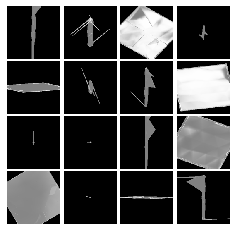

[Epoch 79/1000] [Batch 50/63] [D loss: -3.701136][G loss: 7.865470][Lap loss: 22.314631][z loss: 3.715433] D(x): 3.3311 D(G(z)): -4.5344
[Epoch 80/1000] [Batch 0/63] [D loss: -3.972294][G loss: 7.736224][Lap loss: 28.024927][z loss: 3.297926] D(x): 3.1644 D(G(z)): -4.5718
[Epoch 80/1000] [Batch 50/63] [D loss: -3.847671][G loss: 6.569029][Lap loss: 17.883512][z loss: 3.692477] D(x): 3.0614 D(G(z)): -3.5077
[Epoch 81/1000] [Batch 0/63] [D loss: -3.830902][G loss: 7.679709][Lap loss: 24.459356][z loss: 3.956903] D(x): 3.3037 D(G(z)): -4.3760
[Epoch 81/1000] [Batch 50/63] [D loss: -3.601967][G loss: 6.201915][Lap loss: 19.386578][z loss: 3.746771] D(x): 2.8489 D(G(z)): -3.3530
[Epoch 82/1000] [Batch 0/63] [D loss: -3.401992][G loss: 7.713594][Lap loss: 23.452925][z loss: 3.550920] D(x): 3.2818 D(G(z)): -4.4318
[Epoch 82/1000] [Batch 50/63] [D loss: -3.769492][G loss: 7.789116][Lap loss: 25.636349][z loss: 3.864137] D(x): 3.1834 D(G(z)): -4.6057
[Epoch 83/1000] [Batch 0/63] [D loss: -3.796

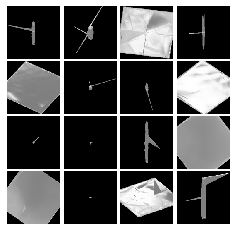

[Epoch 87/1000] [Batch 50/63] [D loss: -3.543863][G loss: 7.088589][Lap loss: 19.137436][z loss: 4.323790] D(x): 2.7761 D(G(z)): -4.3125
[Epoch 88/1000] [Batch 0/63] [D loss: -3.542082][G loss: 7.313973][Lap loss: 20.726238][z loss: 4.942678] D(x): 3.0160 D(G(z)): -4.2979
[Epoch 88/1000] [Batch 50/63] [D loss: -3.750919][G loss: 7.607283][Lap loss: 16.934246][z loss: 4.696034] D(x): 3.0619 D(G(z)): -4.5454
[Epoch 89/1000] [Batch 0/63] [D loss: -3.735422][G loss: 7.161018][Lap loss: 17.701185][z loss: 5.000042] D(x): 2.7996 D(G(z)): -4.3614
[Epoch 89/1000] [Batch 50/63] [D loss: -3.693686][G loss: 7.646424][Lap loss: 18.128174][z loss: 4.646846] D(x): 2.9367 D(G(z)): -4.7097
[Epoch 90/1000] [Batch 0/63] [D loss: -3.261271][G loss: 7.267185][Lap loss: 17.508030][z loss: 4.614830] D(x): 2.8682 D(G(z)): -4.3990
[Epoch 90/1000] [Batch 50/63] [D loss: -3.778951][G loss: 7.539764][Lap loss: 18.407295][z loss: 5.008552] D(x): 2.8089 D(G(z)): -4.7308
[Epoch 91/1000] [Batch 0/63] [D loss: -3.674

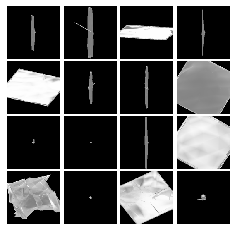

[Epoch 95/1000] [Batch 50/63] [D loss: -3.346501][G loss: 7.190300][Lap loss: 17.064939][z loss: 5.243634] D(x): 2.7955 D(G(z)): -4.3947
[Epoch 96/1000] [Batch 0/63] [D loss: -3.612015][G loss: 6.889299][Lap loss: 19.058695][z loss: 5.266469] D(x): 2.8838 D(G(z)): -4.0055
[Epoch 96/1000] [Batch 50/63] [D loss: -3.559849][G loss: 7.039583][Lap loss: 18.561573][z loss: 5.462340] D(x): 3.0100 D(G(z)): -4.0295
[Epoch 97/1000] [Batch 0/63] [D loss: -3.809746][G loss: 6.947956][Lap loss: 17.051205][z loss: 5.185441] D(x): 2.6646 D(G(z)): -4.2834
[Epoch 97/1000] [Batch 50/63] [D loss: -3.551349][G loss: 7.175796][Lap loss: 19.386253][z loss: 5.265315] D(x): 2.7702 D(G(z)): -4.4056
[Epoch 98/1000] [Batch 0/63] [D loss: -3.665358][G loss: 7.449618][Lap loss: 17.601875][z loss: 4.856715] D(x): 2.8723 D(G(z)): -4.5773
[Epoch 98/1000] [Batch 50/63] [D loss: -3.683851][G loss: 6.771264][Lap loss: 17.063959][z loss: 4.611183] D(x): 2.8316 D(G(z)): -3.9397
[Epoch 99/1000] [Batch 0/63] [D loss: -3.362

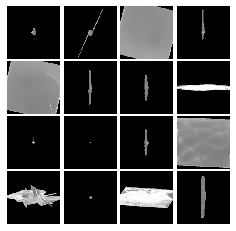

[Epoch 103/1000] [Batch 50/63] [D loss: -3.775101][G loss: 7.019545][Lap loss: 16.436781][z loss: 4.112553] D(x): 2.4378 D(G(z)): -4.5818
[Epoch 104/1000] [Batch 0/63] [D loss: -3.690203][G loss: 6.084155][Lap loss: 13.177191][z loss: 3.985348] D(x): 2.4114 D(G(z)): -3.6728
[Epoch 104/1000] [Batch 50/63] [D loss: -3.707659][G loss: 7.135862][Lap loss: 17.009291][z loss: 3.701948] D(x): 2.2792 D(G(z)): -4.8566
[Epoch 105/1000] [Batch 0/63] [D loss: -3.821500][G loss: 6.843223][Lap loss: 16.704109][z loss: 3.738492] D(x): 2.4443 D(G(z)): -4.3989
[Epoch 105/1000] [Batch 50/63] [D loss: -3.490597][G loss: 6.748800][Lap loss: 15.966621][z loss: 3.353194] D(x): 2.5574 D(G(z)): -4.1914
[Epoch 106/1000] [Batch 0/63] [D loss: -3.488519][G loss: 6.748488][Lap loss: 15.013227][z loss: 3.568650] D(x): 2.4274 D(G(z)): -4.3210
[Epoch 106/1000] [Batch 50/63] [D loss: -3.423675][G loss: 7.544844][Lap loss: 18.316427][z loss: 3.585194] D(x): 2.6087 D(G(z)): -4.9362
[Epoch 107/1000] [Batch 0/63] [D loss

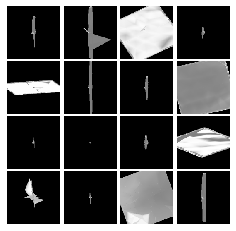

[Epoch 111/1000] [Batch 50/63] [D loss: -3.529528][G loss: 7.794020][Lap loss: 16.751816][z loss: 3.503877] D(x): 2.4956 D(G(z)): -5.2985
[Epoch 112/1000] [Batch 0/63] [D loss: -3.402763][G loss: 6.824172][Lap loss: 15.670311][z loss: 3.767846] D(x): 2.5223 D(G(z)): -4.3018
[Epoch 112/1000] [Batch 50/63] [D loss: -3.457167][G loss: 7.133485][Lap loss: 16.392403][z loss: 2.916631] D(x): 2.3529 D(G(z)): -4.7806
[Epoch 113/1000] [Batch 0/63] [D loss: -3.803875][G loss: 6.843357][Lap loss: 19.608454][z loss: 2.260402] D(x): 2.2386 D(G(z)): -4.6047
[Epoch 113/1000] [Batch 50/63] [D loss: -3.457537][G loss: 7.403199][Lap loss: 15.502722][z loss: 3.341428] D(x): 2.6316 D(G(z)): -4.7716
[Epoch 114/1000] [Batch 0/63] [D loss: -3.718500][G loss: 6.353467][Lap loss: 14.633535][z loss: 2.818301] D(x): 2.4767 D(G(z)): -3.8768
[Epoch 114/1000] [Batch 50/63] [D loss: -3.528975][G loss: 6.888523][Lap loss: 15.474013][z loss: 2.573970] D(x): 2.1862 D(G(z)): -4.7023
[Epoch 115/1000] [Batch 0/63] [D loss

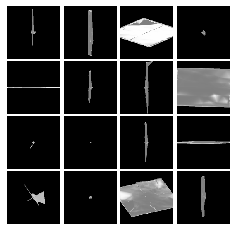

[Epoch 119/1000] [Batch 50/63] [D loss: -3.329980][G loss: 6.922027][Lap loss: 9.686751][z loss: 3.918057] D(x): 2.6278 D(G(z)): -4.2942
[Epoch 120/1000] [Batch 0/63] [D loss: -3.510561][G loss: 7.282750][Lap loss: 14.208356][z loss: 3.635181] D(x): 2.4443 D(G(z)): -4.8384
[Epoch 120/1000] [Batch 50/63] [D loss: -3.441679][G loss: 6.323276][Lap loss: 12.346210][z loss: 4.473372] D(x): 2.5307 D(G(z)): -3.7926
[Epoch 121/1000] [Batch 0/63] [D loss: -3.545142][G loss: 6.766033][Lap loss: 13.443159][z loss: 3.146157] D(x): 2.4177 D(G(z)): -4.3483
[Epoch 121/1000] [Batch 50/63] [D loss: -3.596571][G loss: 6.859134][Lap loss: 15.128462][z loss: 4.237643] D(x): 2.5403 D(G(z)): -4.3189
[Epoch 122/1000] [Batch 0/63] [D loss: -3.465378][G loss: 6.619430][Lap loss: 17.981846][z loss: 3.129540] D(x): 2.4532 D(G(z)): -4.1662
[Epoch 122/1000] [Batch 50/63] [D loss: -3.347189][G loss: 7.145944][Lap loss: 15.166165][z loss: 4.282734] D(x): 2.4525 D(G(z)): -4.6935
[Epoch 123/1000] [Batch 0/63] [D loss:

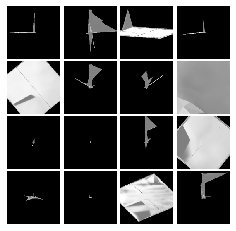

[Epoch 127/1000] [Batch 0/63] [D loss: -3.467346][G loss: 6.749463][Lap loss: 18.006702][z loss: 4.645854] D(x): 2.1958 D(G(z)): -4.5537
[Epoch 127/1000] [Batch 50/63] [D loss: -3.555831][G loss: 7.249596][Lap loss: 14.214609][z loss: 4.496842] D(x): 2.2902 D(G(z)): -4.9594
[Epoch 128/1000] [Batch 0/63] [D loss: -3.369408][G loss: 6.851243][Lap loss: 14.934923][z loss: 4.942389] D(x): 2.2040 D(G(z)): -4.6472
[Epoch 128/1000] [Batch 50/63] [D loss: -3.211472][G loss: 6.814937][Lap loss: 17.339579][z loss: 3.867932] D(x): 2.2007 D(G(z)): -4.6143
[Epoch 129/1000] [Batch 0/63] [D loss: -3.552930][G loss: 7.725785][Lap loss: 16.124107][z loss: 4.977622] D(x): 2.4031 D(G(z)): -5.3227
[Epoch 129/1000] [Batch 50/63] [D loss: -3.401842][G loss: 6.819733][Lap loss: 16.587730][z loss: 2.907471] D(x): 2.4188 D(G(z)): -4.4009
[Epoch 130/1000] [Batch 0/63] [D loss: -3.660656][G loss: 7.006261][Lap loss: 14.874678][z loss: 4.103275] D(x): 2.4392 D(G(z)): -4.5671
[Epoch 130/1000] [Batch 50/63] [D loss

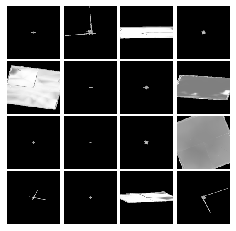

[Epoch 135/1000] [Batch 0/63] [D loss: -3.463563][G loss: 6.540312][Lap loss: 13.647711][z loss: 3.067652] D(x): 2.1838 D(G(z)): -4.3565
[Epoch 135/1000] [Batch 50/63] [D loss: -3.360419][G loss: 6.864655][Lap loss: 14.689651][z loss: 4.818179] D(x): 2.2145 D(G(z)): -4.6502
[Epoch 136/1000] [Batch 0/63] [D loss: -3.276495][G loss: 6.252817][Lap loss: 12.337877][z loss: 3.441640] D(x): 2.3418 D(G(z)): -3.9110
[Epoch 136/1000] [Batch 50/63] [D loss: -3.503356][G loss: 7.507124][Lap loss: 15.411241][z loss: 4.590980] D(x): 2.4245 D(G(z)): -5.0826
[Epoch 137/1000] [Batch 0/63] [D loss: -3.530211][G loss: 6.877648][Lap loss: 13.454179][z loss: 5.455906] D(x): 2.3017 D(G(z)): -4.5760
[Epoch 137/1000] [Batch 50/63] [D loss: -3.244138][G loss: 7.273684][Lap loss: 14.749246][z loss: 2.530399] D(x): 2.2326 D(G(z)): -5.0410
[Epoch 138/1000] [Batch 0/63] [D loss: -3.336208][G loss: 6.791748][Lap loss: 12.163050][z loss: 3.029015] D(x): 2.3833 D(G(z)): -4.4084


In [ ]:
# Training Loop
# Automatic GPU/CPU device placement
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

NORM = 'l2'

# Lists to keep track of progresss
img_list = []
G_losses = []
D_losses = []
R_losses = []
Lap_losses = []
iters = 0

adversarial_loss = nn.BCEWithLogitsLoss()

from soft_renderer import LaplacianLoss

laplacian_loss = LaplacianLoss(netG.mesh_generator.sphere_vs.cpu(), netG.sphere_fs[0].cpu(), average=True).cuda()
# Loss weight for gradient penalty
lambda_lap = 1



if os.path.exists(checkpoint_file):
    if resume:
        checkpoint = torch.load(checkpoint_file)
        netD.load_state_dict(checkpoint['netD'])
        netG.load_state_dict(checkpoint['netG'])
        netR.load_state_dict(checkpoint['netR'])
        optimizer_D.load_state_dict(checkpoint['optimizer_D'])
        optimizer_G.load_state_dict(checkpoint['optimizer_G'])
        optimizer_R.load_state_dict(checkpoint['optimizer_R'])

print("Starting Training Loop...")
# For each epoch
lap_initialized = False

last_lap_loss = 1e3

for epoch in range(num_epochs):
    # For each batch in the dataloader
    #last_g_error = 1.0
    for i, data in enumerate(dataloader, 0):
        
        batch = data[0]
        batch_size_i = batch.shape[0]
        # Adversarial ground truths
        valid = torch.cuda.FloatTensor(batch_size_i, 1).fill_(real_label)
        fake = torch.cuda.FloatTensor(batch_size_i, 1).fill_(fake_label)
        # Configure input
        #noise = torch.cuda.Tensor(*batch.shape).normal_(0.0, 0.05)
        real_imgs = batch.cuda() - 0.5 #+ noise

        for j in range(2):
            # Tune gradient computations
            for param in netG.parameters():
                param.requires_grad_(False)
            for param in netD.parameters():
                param.requires_grad_(True)
            for param in netR.parameters():
                param.requires_grad_(False)


            z_sample = torch.randn(batch_size_i, nz).to(device) # Sample prior from Gaussian distribution
            x_sample = real_imgs

            with torch.no_grad():
                x_fake, x_fake_vertices = netG(z_sample)
            x_real_score = netD(x_sample)
            x_fake_score = netD(x_fake)

            # Zerofy the gradients
            optimizer_D.zero_grad()

            # Compute loss
            d_loss = x_real_score - x_fake_score
            if NORM == 'l1':
                d_norm = 10 * (x_sample - x_fake).abs().mean()
            elif NORM == 'l2':
                d_norm = 10 * ((x_sample - x_fake)**2).mean().sqrt()
            d_loss = - d_loss + 0.5 * d_loss**2 / d_norm
            d_loss = d_loss.mean()

            # Compute gradients
            d_loss.backward()

            if last_lap_loss < lambda_lap:
                if not lap_initialized:
                    lap_initialized = True
                    print("Laplacian has been initialized. Discriminator will begin training.")

            if lap_initialized:# and g_adv_loss.item() < 20.0:
                optimizer_D.step()

        # Update the network(s)
            #optimizer_D.step()

        #################
        # Train g_model #
        #################

        # Tune gradient computations
        for param in netG.parameters():
            param.requires_grad_(True)
        for param in netD.parameters():
            param.requires_grad_(False)
        for param in netR.parameters():
            param.requires_grad_(True)
        
        
        z_sample = torch.randn(batch_size_i, nz).to(device) # Sample prior from Gaussian distribution
        x_sample = real_imgs

        x_fake, x_fake_vertices = netG(z_sample)
        x_real_score = netD(x_sample)
        x_fake_score = netD(x_fake)
        
        z_recon = netR(x_fake_vertices)
        z_diff_loss = torch.mean((z_recon - z_sample) ** 2)

        # Zerofy the gradients
        optimizer_G.zero_grad()

        # Compute loss
        g_adv_loss = x_real_score - x_fake_score
        g_adv_loss = g_adv_loss.mean()
        
        lap_loss = laplacian_loss(x_fake_vertices) * lambda_lap
        last_lap_loss = lap_loss.item()
        g_loss = g_adv_loss + z_diff_loss + lap_loss

        # Compute gradients
        g_loss.backward()

        # Update the network(s)
        optimizer_G.step()
        optimizer_R.step()
            
        
        D_losses.append(d_loss.item())
        G_losses.append(g_loss.item())
        R_losses.append(z_diff_loss.item())
        
        #Lap_losses.append(lap_loss.item())

        if i % 50 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f][G loss: %f][Lap loss: %f][z loss: %f] D(x): %.4f D(G(z)): %.4f"
                % (epoch, num_epochs, i, len(dataloader), d_loss.item(), g_adv_loss.item(),
                lap_loss.item(), z_diff_loss.item(), x_real_score.mean().item(), x_fake_score.mean().item()),
            )
            
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise)[0][:,:3].detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            imgs_numpy = fake.numpy()
            show_images(imgs_numpy[0:16])
            plt.show()
        
        iters += 1
    
    torch.save({
        'netD': netD.state_dict(),
        'netG': netG.state_dict(),
        'netR': netR.state_dict(),
        'optimizer_D': optimizer_D.state_dict(),
        'optimizer_G': optimizer_G.state_dict(),
        'optimizer_R': optimizer_R.state_dict(),
    }, checkpoint_file)

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(60,60))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:batch_size, :3], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()